In [1]:
import kagglehub
import json
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from triton.language import dtype

# Download latest version
path = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path)

Path to dataset files: /home/antoine/.cache/kagglehub/datasets/rhammell/ships-in-satellite-imagery/versions/9


In [2]:
jsondata = json.load(open(path + "/shipsnet.json"))
nb_data = len(jsondata["data"])

In [3]:
len(jsondata["scene_ids"])

4000

In [4]:
len(jsondata["data"][0])

19200

In [5]:
def rescale_patch(patch, new_size=(16,16)):
    patch_uint8 = (patch * 255).clip(0, 255).astype(np.uint8) if patch.dtype != np.uint8 else patch
    pil_img = Image.fromarray(patch_uint8)
    downscaled_image = pil_img.resize(new_size, Image.Resampling.LANCZOS)
    downscaled_np = np.array(downscaled_image)
    return downscaled_np

def parse_img(data_unparsed, new_size = (16,16)):
    size = len(data_unparsed)
    assert size == 3 * 80 * 80, "Wrong data feeded"
    r_channels = data_unparsed[:size // 3]
    g_channels = data_unparsed[size // 3: 2*size//3]
    b_channels = data_unparsed[2*size//3:]
    pixels = np.array([r_channels, g_channels, b_channels], dtype=np.uint8).T
    pixels = pixels.reshape((80, 80, 3))
    downscaled_np = rescale_patch(pixels, new_size=new_size)
    return downscaled_np

In [6]:
def plot_image_grid(data, k):
    """
    Plots a k x k grid of images
    """
    fig, axes = plt.subplots(k, k, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)   
    
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(data): 
            ax.imshow(data[i])  
            ax.axis('off')  # Hide axes
        else:
            ax.axis('off')

    plt.show()

In [7]:
def plot_image_grid(data, k, figsize = (4,4)):
    """
    Plots a k x k grid of images
    """
    fig, axes = plt.subplots(k, k, figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(data):
            ax.imshow(data[i])
            ax.axis('off')  # Hide axes
        else:
            ax.axis('off')

    plt.show()




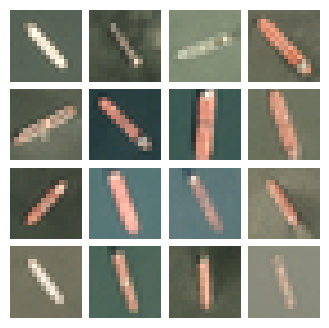

In [8]:
patch_size = (16,16)

patches = []
y_true = np.array(jsondata["labels"])
x = np.array(list(map(lambda x : parse_img(x, new_size=patch_size), jsondata["data"])))


plot_image_grid(x, 4)

In [9]:
def preprocessing(datas):
    """
    
    :param datas: (n_samples, n_rows, n_cols, n_channels)
    :return: 
    """
    n_samples, n_rows, n_cols, n_channels = datas.shape
    datas = datas.reshape(n_samples, -1) / 255
    preprocessed = datas
    infos = {"shape" : (n_rows, n_cols)}
    return  preprocessed, infos

def postprocessing(datas, infos, ):
    n_rows, n_cols = infos["shape"]
    results = datas
    results = results.reshape(len(datas), n_rows, n_cols, 3, order="C").clip(0,1)
    return results



In [10]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y_true, test_size=0.2)



In [11]:
x_boat = x[y_true == 1.]
x_background = x[y_true == 0.]
x_background_preprocessing, infos_background_preprocessing = preprocessing(x_background)
x_boat_preprocessing, infos_boat_preprocessing = preprocessing(x_boat)

print(" training data shape", x_background_preprocessing.shape)

 training data shape (3000, 768)


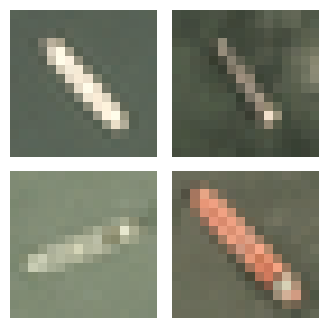

In [12]:
plot_image_grid(x_boat, 2)

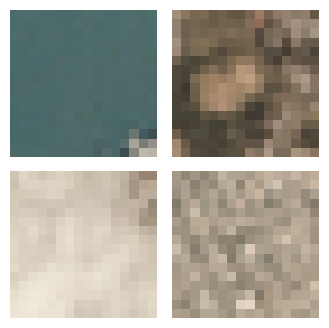

In [13]:
plot_image_grid(x_background, 2)

In [52]:
def get_own_implementation_dico():
    
    from src.dictionary.dictionary_algo import  DictionaryAlgoParallel
    m = patch_size[0] * patch_size[1]*3
    nb_atoms = 30
    dict_learner = DictionaryAlgoParallel(m=m, k=nb_atoms, lbd=1e-2, dic_update_steps=2, use_cuda=False, dico_update="quick_update", n_jobs=-1, verbose=True)
    
    from tqdm import tqdm
    from itertools import cycle
    class FiniteGenerator:
        def __init__(self, iterable, nb_elt,  batch_size = 8):
            self.iterable = iterable
            self.nb_elt = nb_elt
            self.batch_size = batch_size
        def __len__(self):
            return self.nb_elt
        def __iter__(self,):
            infinite_loader = cycle(self.iterable)          
            for k in tqdm(range(self.nb_elt // self.batch_size)):
                data = np.array([next(infinite_loader) for _ in range(self.batch_size)])
                yield torch.from_numpy(data).float()
                
    x_training = FiniteGenerator(x_background_preprocessing, 4*len(x_boat_preprocessing), batch_size=32)
    dict_learner.D = torch.tensor(torch.from_numpy(x_background_preprocessing[:nb_atoms].T), dtype=torch.float)
    dict_learner.D.to(dict_learner.device)
    dict_learner.fit(x_training)
    return dict_learner
def get_sklearn_implementation_dico():
    from sklearn.decomposition import MiniBatchDictionaryLearning
    dict_learner = MiniBatchDictionaryLearning( n_components=30, batch_size=64, transform_algorithm='lasso_lars', transform_alpha=0.01, max_iter=20, random_state=42, verbose=True, max_no_improvement=500)
    x_training = x_background_preprocessing
    dict_learner.fit(x_training)
    return dict_learner

## Dictionary training 

we train our dictionary on the background dataset.

you may choose either to use our implementation of dictionary learning or the Sklearn one.

In [53]:
#dict_learner = get_sklearn_implementation_dico()
dict_learner = get_own_implementation_dico()





100%|██████████| 125/125 [00:06<00:00, 19.67it/s]


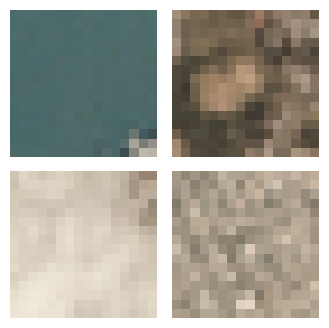

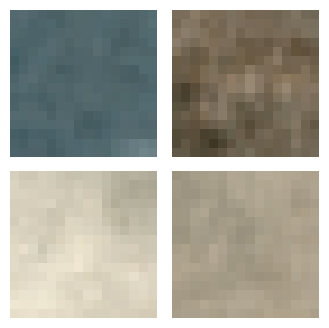

In [54]:
def make_prediction(X,infos_preprocessing, dict_learner):
    weights_encoded = dict_learner.transform(X)
    #print(weights_encoded.shape, dict_learner.components_.shape)
    x_transformed = weights_encoded @ dict_learner.components_
    x_transformed = postprocessing(x_transformed, infos_preprocessing)
    return x_transformed

x_transformed = make_prediction(x_background_preprocessing, infos_background_preprocessing, dict_learner)
plot_image_grid(x_background, 2)
plot_image_grid(x_transformed, 2)

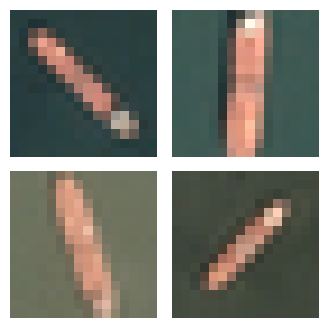

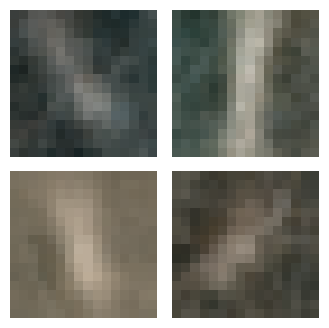

In [55]:
x_transformed_boat = make_prediction(x_boat_preprocessing, infos_boat_preprocessing, dict_learner)
plot_image_grid(x_boat[5:], 2)
plot_image_grid(x_transformed_boat[5:], 2)

## Image segmentation based on patch from an image

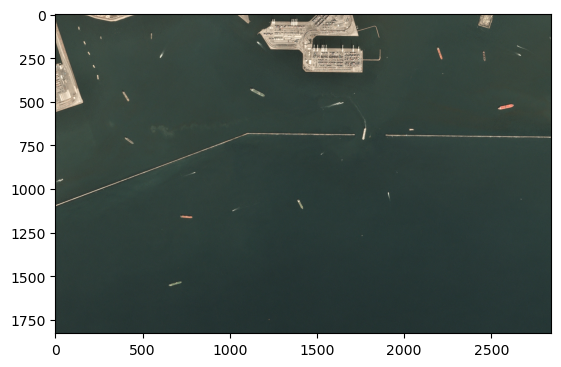

In [56]:
image_path = path + "/scenes/scenes/lb_2.png"
image = Image.open(image_path).convert("RGB")  # Ensure it is RGB format
plt.imshow(image)

In [57]:
image_np = np.array(image)
print(image_np.shape)

(1828, 2844, 3)


w pixel cropped : 68 
 l pixel cropped : 44


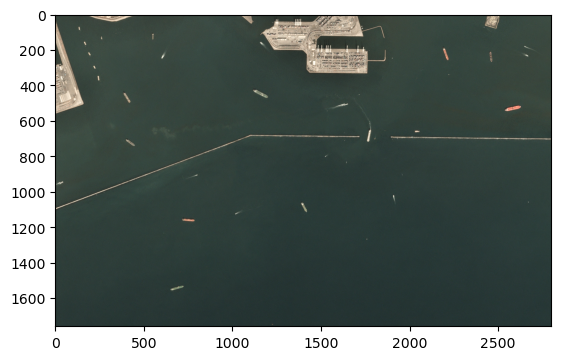

In [58]:
def get_pacthed_image(image_np, patch_size):
    
    w, l, c = image_np.shape  #
    k = patch_size

    w_crop = (w // k) * k
    l_crop = (l // k) * k
    cropped_shape = (w_crop, l_crop,c)
    print("w pixel cropped :", w - w_crop, "\n l pixel cropped :", l - l_crop)
    image_cropped = image_np[:w_crop, :l_crop, :]

    patches = image_cropped.reshape(w_crop // k, k, l_crop // k, k, c)
    patches = patches.transpose(0, 2, 1, 3, 4)  # (num_patches_h, num_patches_w, k, k, c)
    patches = np.reshape(patches, (patches.shape[0] * patches.shape[1], patches.shape[2], patches.shape[3], patches.shape[4])) # num_patches, k, k, c
    return patches, cropped_shape

def get_unpatched_image(patches, image_shape):
    h, w, c = image_shape
    patch_size = patches.shape[1]
    k = patch_size
    num_patches_h = h // k
    num_patches_w = w // k
    patches = patches.reshape(num_patches_h, num_patches_w, k, k, c)
    patches = patches.transpose(0, 2, 1, 3, 4)
    image = patches.reshape(h, w, c)
    return image


patches, cropped_shape = get_pacthed_image(image_np, 80)
reconstructed = get_unpatched_image(patches, cropped_shape)
plt.imshow(reconstructed)

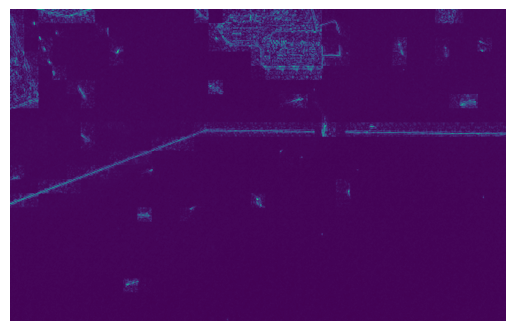

In [59]:
patches_downscaled = np.array(list(map(lambda x : rescale_patch(x, new_size=patch_size), patches))) 
patches_preprocessed, infos_inference_preprocessed = preprocessing(patches_downscaled)
x_transformed_inference = make_prediction(patches_preprocessed, infos_inference_preprocessed, dict_learner)
x_postprocess_inference = postprocessing(x_transformed_inference, infos_inference_preprocessed)
l_2_patch_differences=  np.abs(x_postprocess_inference - patches_downscaled / 255)
l_2_patch_differences_upscaled = np.array(list(map(lambda x : rescale_patch(x, new_size=(80,80)), l_2_patch_differences)))
reconstructed = get_unpatched_image(l_2_patch_differences_upscaled, cropped_shape)
reconstructed = reconstructed.mean(axis=-1)
fig, ax = plt.subplots()  
ax.axis('off')           
ax.imshow(reconstructed)  
plt.show()                



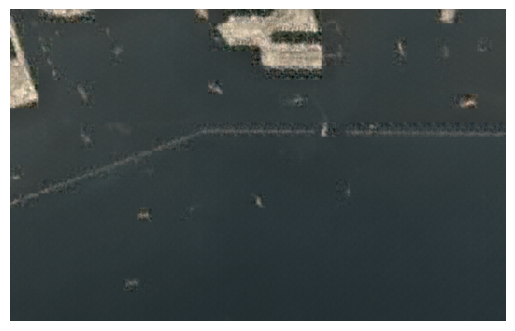

In [60]:
generated_patches_upscaled = np.array(list(map(lambda x : rescale_patch(x, new_size=(80,80)), x_postprocess_inference)))
generated_img = get_unpatched_image(generated_patches_upscaled, cropped_shape)

fig, ax = plt.subplots()  
ax.axis('off')           
ax.imshow(generated_img)  
plt.show()                


Example of element of the dictionary

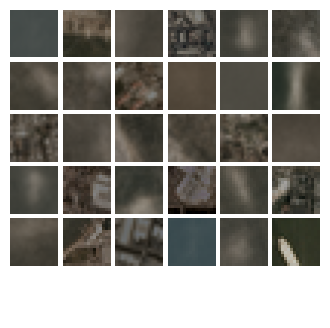

In [61]:
dico = dict_learner.components_
x_transformed = postprocessing(dico, infos_boat_preprocessing)
plot_image_grid(8*x_transformed, 6)